# Standardizing PGAM fits
--------------------------------------

In this notebook we propose a pipeline for fitting PGAMs (Balzani et al., 2020, NeurIPS) with a standard input and output format. The procedure has the following advantages:

1. It requires minimal coding (limited to formatting the input data in a standard format)
2. The output format is easily exportable to other tools and programing languages (e.g., MATLAB)
3. The pipeline is compatible with the PGAM <a href="https://hub.docker.com/r/edoardobalzani87/pgam"> Docker</a> and <a href="https://osf.io/pcsav/"> Singularity</a> images.
4. The pipleine can be easily parallelized for HPC usage (singularity containers).


## Table of contents
* [Standard input format](#standard-input-format)
    * [Neural & behavioral inputs](#inputs)
    * [Configuration files](#configuration-files)
* [Example with synthetic data](#example-with-synthetic-data)
    * [Create and save an example configuration file](#create-and-save-conf)
    * [Fittng the model](#fitting-model)
        * [List the fits by experiment, condition, neuron, and model configuration](#fit-list)
        * [Load inputs, fit and postprocess](#load-fit-save)
* [Example with real data](#example-with-real-data)
    * [Create and save an example configuration file](#create-and-save-conf-for-real-data)
    * [Fittng the model](#fitting-model-for-real-data)
        * [List the fits by experiment, condition, neuron, and model configuration](#fit-list-real-data)
        * [Load inputs, fit and postprocess](#load-fit-save-real-data)
* [Fit via docker](#docker)
    * [Mounting volumes](#mount-volumes)
    * [Setting paths](#container-path)
    * [Fit by running the container](#fit-container)
* [HPC & singularity ](#HPC)



## Standard input format <a name="standard-input-format"></a>

In order to fully specify the PGAM model we need:

1. A matrix containing the population <a href="#counts" >spike counts</a> (to be used as response variable and/or covariates), and a list with the <a href="#neu_names">neuron identifiers</a>

2. A matrix containing the <a href="#variables" >task variables</a> (additional covariates), and a list with the respective <a href="#variable_names" >identifiers</a>

3. A vector containing <a href="#trial_id" >trial IDs</a>

4. A list of <a href="#trial_id" >covariates</a> to be included and the ID of the unit that we want to fit.

5. A <a href="#configuration-files" >configuration file</a> listing the model parameters in "YAML" file format
    
We propose the following standard input format to facilitate model specification, fitting, and saving. 

### **Neural & behavioral inputs [1-4].** <a name="inputs"></a>

Inputs [1-4] will be contained in a single ".npz" files with keys: 

- **counts**: <a name="counts"></a>numpy.array of dimension (T x N), where T is the total number of time points (bins), and N is the number of neurons. The code has been extensively tested with bins of size 6ms, but works for any size.
- **variables**: <a name="variables"></a>numpy.array of dimension (T x M), T as above (same bin size), M the number of task variables. For continous variables, each entry is the value taken by the associated variable. For event variables, it is "1-hot-encoding": zeros everywhere except for when the event happens, taking a value of '1'. 
- **trial_id**: <a name="trial_id"></a>numpy.array of dimension T, trial ids associated to each time point. All time points for a given trial take the same value. 
- **variable_names**: <a name="variable_names"></a>numpy.array of strings of dimension M, name of each covariate in 'variables'.
- **neu_names**: <a name="neu_names"></a>numpy.array of strings of dimension N, label uniquely identifying the neurons in 'counts'
- **neu_info**: dict, *optional
    neu_info[neu_names[k]]: <a name="neu_info"></a>dict, info about the k-th neuron, $k=0,\dots,N-1$. keys are the information label.


### **Configuration files [5]**<a name="configuration-files"></a>

Input [5], the configuration parameters for the B-spline, will be stored with the "YAML" file format. Python dict objects can be readily saved in YAML format as follows,




```python
    import yaml
    with open('data.yml', 'w') as outfile:
        yaml.dump(python_dictionary, outfile, default_flow_style=False)
```

where *python_dictionary* is any python dict object whose values are strings, numeric, list containig strings or numeric, or dict.

To read a "YAML"

```python
    with open("data.yaml", "r") as stream:
        try:
            python_dicttionary = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
```

The dictionary with the "YAML" should be structured as follows:
```yaml
    var_1: # This is an example of a continous variable. "var_1" should match an entry in either "variable_names". 
      is_temporal_kernel: false # false for continous variable, true for events (example below)
      kernel_direction: .nan # '.nan' when "is_temporal_kernel: false". When "true", 0 = acausal (bidirectional), '1' = causal (i.e., firing change after the event happens), '-1' = anticipatory (i.e., firing change before event happens).
      kernel_length: .nan
      order: 4 # Order of the B-spline. A step-function is order = 1. 
      knots_num: .nan # ".nan" will use the knots passed (below). An integer will place knots equi-spaced.
      knots: # knots for tuning function. The first and last entries are repeated order-times (given recursive nature of B-spline definition).
      - -2.0
      - -2.0
      - -2.0
      - -2.0
      - -1.6
      - -1.2
      - -0.7999999999999998
      - -0.3999999999999999
      - 0.0
      - 0.40000000000000036
      - 0.8000000000000003
      - 1.2000000000000002
      - 1.6
      - 2.0
      - 2.0
      - 2.0
      - 2.0
      penalty_type: der # either 'der' or 'diff'. 'der' is derivate-based penality, 'diff' is difference based penality (see Tutorial 1:PGAM tutorial.ipynb) 
      der: 2 # order of the derivative used for penalization ('2' means second derivative, penalized wiggliness). Default is '2'.
      is_cyclic: # note: should be a vector.
      - false
      lam: 10 # initial lambda for regularization (i.e., how strong is the smoothing penalization. The larger, the more smoothing you get. This is just for initial value, hyper-parameter that is learned in fitting).
      samp_period: 0.006 #size of bin for spike counts and behavioral variables (in seconds).
    var_2: # This is an example of an event variable (temporal kernel). Name of "var_2" has to be in "variable_names". 
      is_temporal_kernel: true
      kernel_direction: 0 # acausal filter (meaning impact of event on firing could happen earlier or after event)
      kernel_length: 201 # number of time-points of the total kernel (in this example 201 samples x 6ms). Suggested to be odd number of samples.
      order: 4
      knots_num: 8 # will create equi-spaces knots.
      knots: .nan # '.nan' when 'knots_num' is an integer.
      penalty_type: der
      der: 2
      is_cyclic:
      - false
      lam: 10
      samp_period: 0.006
    neuron_X: # Where "neuron X" is an input in "neu_names"
      is_temporal_kernel: true
      kernel_direction: 1 # must be '1' for auto-correlation.
      kernel_length: 201
      order: 4
      knots_num: 8
      knots: .nan
      penalty_type: der      
      der: 2  
      is_cyclic:
      - false
      lam: 10
      samp_period: 0.006
    
```

where ***var_1*** is a prototypical continous (spatial) variable, ***var_2*** is a prototypical event (temporal) variable. ***spike_history*** will be used for the spike-count auto-correlation term (e.g. the neural spike history as its own predictor, as in an auto-regressive model) **and for the neural couplings (e.g. the counts of simultaneously recoded neurons as predictors)**. See the "PGAM tutorial.ipynb" for a definition of continous (spatial) and event (temporal) variables, as well as for a description of the B-spline parameters.


# Example with synthetic data <a name="example-with-synthetic-data"></a>

Before diving into the pipeline implementation, we will create an example synthetic dataset below.


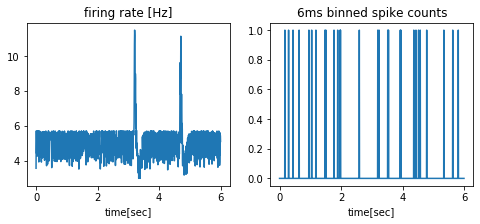

In [1]:
import numpy as np
import sys
sys.path.append('src/PGAM/')
from GAM_library import *
import gam_data_handlers as gdh
import matplotlib.pylab as plt
import pandas as pd
from post_processing import postprocess_results
import scipy.stats as sts

# flag if you want to save the in-silico data
save_output = True

## inputs parameters
num_events = 600
time_points = 10 ** 5  # 10 mins at 0.006 second resolution
rate = 5. * 0.006  # Hz rate of the final kernel
variance = 5.  # variance of input (modeled to be Gaussian)
int_knots_num = 20  # num of internal knots for the spline basis
order = 4  # spline order

## trial_ids: numpy.array of dim T, trial ids associated to each time point, assume 200 trials
trial_ids = np.repeat(np.arange(200),time_points//200)

## create event (temporal) input
idx = np.random.choice(np.arange(time_points), num_events, replace=False)
events = np.zeros(time_points)
events[idx] = 1

## create continous (spatial) variables (spatial_var will drive the neuron, nuisance_var will not drive the neuron)
rv = sts.multivariate_normal(mean=[0, 0], cov= variance * np.eye(2))
samp = rv.rvs(time_points)
spatial_var = samp[:, 0]
nuisance_var = samp[:, 1]

# truncate inputs to avoid jumps in the resp function
sele_idx = np.abs(spatial_var) < 5
spatial_var = spatial_var[sele_idx]
nuisance_var = nuisance_var[sele_idx]
while spatial_var.shape[0] < time_points:
    tmpX = rv.rvs(10 ** 4)
    sele_idx = np.abs(tmpX[:, 0]) < 5
    tmpX = tmpX[sele_idx, :]

    spatial_var = np.hstack((spatial_var, tmpX[:, 0]))
    nuisance_var = np.hstack((nuisance_var, tmpX[:, 1]))
spatial_var = spatial_var[:time_points]
nuisance_var = nuisance_var[:time_points]

# create a response function (for ground-truth)
knots = np.hstack(([-5]*3, np.linspace(-5,5,8),[5]*3))
beta = np.arange(10)
beta = beta / np.linalg.norm(beta)
beta = np.hstack((beta[5:], beta[:5][::-1]))
resp_func = lambda x : np.dot(gdh.splineDesign(knots, x, order, der=0),beta)

filter_used_conv = sts.gamma.pdf(np.linspace(0,20,100),a=2) - sts.gamma.pdf(np.linspace(0,20,100),a=5)
filter_used_conv = np.hstack((np.zeros(101),filter_used_conv))*2


# mean of the spike counts depending on spatial_var and events
log_mu0 = resp_func(spatial_var)
for tr in np.unique(trial_ids):
    log_mu0[trial_ids == tr] = log_mu0[trial_ids == tr] + np.convolve(events[trial_ids == tr], filter_used_conv, mode='same')

# adjust mean rate
const = np.log(np.mean(np.exp(log_mu0)) / rate)
log_mu0 = log_mu0 - const

# generate spikes
spk_counts = np.random.poisson(np.exp(log_mu0))

# plot the firing rate and the spike counts generated
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(np.arange(1000) * 0.006, np.exp(log_mu0)[:1000]/0.006)
plt.title('firing rate [Hz]')
plt.xlabel('time[sec]')

plt.subplot(122)
plt.plot(np.arange(1000) * 0.006, spk_counts[:1000])
plt.title('6ms binned spike counts')
plt.xlabel('time[sec]')

### save the inputs in the standard formats

## counts: numpy.array of dim (T x N), where T is the total number of time points, N is the number of neurons
spk_counts = spk_counts.reshape(-1,1) # population of a single neuron

## variables: numpy.array of dim (T x M), T as above, M the number of task variables
variables = np.zeros((spk_counts.shape[0],3))
variables[:, 0] = spatial_var
variables[:, 1] = nuisance_var
variables[:, 2] = events

## variable_names: numpy.array of strings of dimension M, name of each covariate in 'variables'
variable_names = ['spatial_1', 'spatial_2', 'events']

## neu_names: numpy.array of strings of dimension N, label uniquely identifying the neurons in 'counts'
neu_names = ['neuron_A']

## neu_info: dict, *optional neu_info[neu_names[k]]: dict, info about the k-th neuron, 𝑘=0,…,𝑁-1.
## keys are the information label.
neu_info = {'neuron_A': {'unit_type':'SUA', 'area':'dlPFC'}}

if save_output:
    np.savez('example_data.npz', counts=spk_counts.reshape(-1,1), variables=variables,variable_names=variable_names,
        neu_names=neu_names, neu_info=neu_info, trial_ids=trial_ids)

## Create and save an example configuration file <a name="create-and-save-conf"></a>


Below the code for an example configuration file. 

In [2]:
import yaml
import numpy as np
# Create a YAML cofiguration file and save
order = 4
knots_1 = np.hstack(([-5]*(order-1), np.linspace(-5,5,15),[5]*(order-1)))
knots_2 = np.hstack(([-6]*(order-1), np.linspace(-5,5,15),[6]*(order-1)))


# convert to float (instead np.float64, produce a yaml human readable yaml list, optional)
knots_1 = [float(k) for k in knots_1]
knots_2 = [float(k) for k in knots_2]


## change order of this example to match above
cov_dict = {
    'spatial_1' : {
        'lam':10, 
        'penalty_type': 'der', 
        'der': 2, 
        'knots': knots_1,
        'order':order,
        'is_temporal_kernel': False,
        'is_cyclic': [False],
        'knots_num': np.nan,
        'kernel_length': np.nan,
        'kernel_direction': np.nan,
        'samp_period':0.006 
    },
    'spatial_2' : {
        'lam':10, 
        'penalty_type': 'der', 
        'der': 2, 
        'knots': knots_2, # need to change this above, in the description of the variables
        'order':order,
        'is_temporal_kernel': False,
        'is_cyclic': [False],
        'knots_num': np.nan,
        'kernel_length': np.nan,
        'kernel_direction': np.nan,
        'samp_period':0.006 
    },
    'events':
    {
        'lam':10,
        'penalty_type':'der',
        'der':2,
        'knots': np.nan,
        'order':order,
        'is_temporal_kernel': True,
        'is_cyclic': [False],
        'knots_num': 10,
        'kernel_length': 301,
        'kernel_direction': 1,
        'samp_period':0.006 
    },
    'neuron_A':
    {
        'lam':10,
        'penalty_type':'der',
        'der':2,
        'knots': np.nan,
        'order':order,
        'is_temporal_kernel': True,
        'is_cyclic': [False],
        'knots_num': 8,
        'kernel_length': 201,
        'kernel_direction': 1,
        'samp_period':0.006 
    }
}

# save the yaml config
with open('config_example_data.yml', 'w') as outfile:
    yaml.dump(cov_dict, outfile, default_flow_style=False)
    

# # load the yaml config
# with open("demo/config_pgam.yml", "r") as stream:
#     try:
#         cov_dict = yaml.safe_load(stream)
#     except yaml.YAMLError as exc:
#         print(exc)


## Fitting the model <a name="fitting-model"></a>

### List the fits by experiment, condition, neuron, and model configuration <a name="fit-list"></a>

Once the configuration file has been set-up, we will need a list of fits to be performed. An individual fit is identified by the experiment type, the session, the neuron ID, and the model configuation.

When testing different models (including different subset of task variables, changing knots location and density, etc.) one needs to only modify the configuration files, and update the list of fits appropriately. 

We will again organize the list of fits as a YAML file with the following categories:
 
- **experiment_ID**: string, experiment ID

- **session_ID**: string, session ID

- **neuron_num**: int, the neuron number (from 0 to N-1, whee N is the number of units in the session)

- **path_to_input**: string, the path to the input data

- **path_to_config**: string, the path to the configuration file

- **path_to_output**: string, the path to the output folder where results will be saved


In [3]:
# create and save the YAML with the fit list (1 fit only)
fit_dict = {
    'experiment_ID': ['exp_1'],
    'session_ID': ['session_A'],
    'neuron_num': [0],
    'path_to_input': ['example_data.npz'],
    'path_to_config': ['config_example_data.yml'],
    'path_to_output': ['.']
} 
# save the yaml fit list
with open('fit_list_example_data.yml', 'w') as outfile:
    yaml.dump(fit_dict, outfile, default_flow_style=False)



### Load inputs, fit, and postprocess <a name="load-fit-save"></a>

 
The code below loads the input data, the configurations, fits the model, post-process, and save the results. The following lines of code are also saved as separate script in 'PGAM/utils/fit_from_config.py'

In [4]:

# import libs
import numpy as np
import sys,os
sys.path.append('src/PGAM/') 

import GAM_library as gl
import gam_data_handlers as gdh
from post_processing import postprocess_results
import yaml
import statsmodels.api as sm
from scipy.io import savemat

np.random.seed(4)

#################################################
# User defined input
#################################################

# frac of the trials used for fit eval
frac_eval = 0.2 

# PATH to fit list
path_fit_list = 'fit_list_example_data.yml'

# save as mat
save_as_mat = True
#################################################


# load the job id (either as an input form the command line, or as a default value if not passed)
argv = sys.argv
if len(argv) == 2: # assumes the script is run the command "python fit_from_config.py fit_num"
    fit_num = int(sys.argv[1]) - 1 # HPC job-array indices starts from 1.
else:
    fit_num = 0 # set a default value


# load fit info
with open(path_fit_list, 'r') as stream:
    fit_dict = yaml.safe_load(stream)
    
# unpack the info and load the data
experiment_ID = fit_dict['experiment_ID'][fit_num]
session_ID = fit_dict['session_ID'][fit_num]
neuron_num = fit_dict['neuron_num'][fit_num]
path_to_input = fit_dict['path_to_input'][fit_num]
path_to_config = fit_dict['path_to_config'][fit_num]
path_out = fit_dict['path_to_output'][fit_num]

print('FIT INFO:\nEXP ID: %s\nSESSION ID: %s\nNEURON NUM: %d\nINPUT DATA PATH: %s\nCONFIG PATH: %s\n\n'%(
    experiment_ID,session_ID,neuron_num+1,path_to_input,path_to_config))

# load & unpack data and config
data = np.load(path_to_input, allow_pickle=True)
counts = data['counts']
variables = data['variables']
variable_names = data['variable_names']
neu_names = data['neu_names']
trial_ids = data['trial_ids']
if 'neu_info' in data.keys():
    neu_info = data['neu_info'].all()
else:
    neu_info = {}

with open(path_to_config, 'r') as stream:
    config_dict = yaml.safe_load(stream)

# create a train and eval set (approximately with the right frac of trials)
train_trials = trial_ids % (np.round(1/frac_eval)) != 0
eval_trials = ~train_trials

# create and populate the smooth handler object
sm_handler = gdh.smooths_handler()
for var in config_dict.keys():
    print('adding %s...'%var)
    # check if var is a neuron or a variable
    if var in variable_names:
        x_var = np.squeeze(variables[:, np.array(variable_names) == var])
    elif var in neu_names:
        x_var = np.squeeze(counts[:, np.array(neu_names) == var])
    else:
        raise ValueError('Variable "%s" not found in the input data!'%var)
    
    knots = config_dict[var]['knots']
    
    if np.isscalar(knots):
        knots = None
    else:
        knots = [np.array(knots)]

    lam = config_dict[var]['lam']
    penalty_type = config_dict[var]['penalty_type']
    der = config_dict[var]['der']
    order = config_dict[var]['order']  
    is_temporal_kernel = config_dict[var]['is_temporal_kernel']
    is_cyclic =  config_dict[var]['is_cyclic']
    knots_num = config_dict[var]['knots_num']
    kernel_length = config_dict[var]['kernel_length']
    kernel_direction = config_dict[var]['kernel_direction']
    samp_period = config_dict[var]['samp_period']
    
    # rename the variable as spike hist if the input is the spike counts of the neuron we are fitting
    if var == neu_names[neuron_num]:
        label = 'spike_hist'
    else:
        label = var
    
    sm_handler.add_smooth(label, [x_var], knots=knots, ord=order, is_temporal_kernel=is_temporal_kernel,
                     trial_idx=trial_ids, is_cyclic=is_cyclic, penalty_type=penalty_type, der=der, lam=lam,
                         knots_num=knots_num, kernel_length=kernel_length,kernel_direction=kernel_direction,
                         time_bin=samp_period)

link = sm.genmod.families.links.log()
poissFam = sm.genmod.families.family.Poisson(link=link)

spk_counts = np.squeeze(counts[:, neuron_num])

# create the pgam model
pgam = gl.general_additive_model(sm_handler,
                              sm_handler.smooths_var, # list of coovarate we want to include in the model
                              spk_counts, # vector of spike counts
                              poissFam # poisson family with exponential link from statsmodels.api
                             )

print('\nfitting neuron %s...\n'%neu_names[neuron_num])
full, reduced = pgam.fit_full_and_reduced(sm_handler.smooths_var, 
                                          th_pval=0.001,# pval for significance of covariate icluseioon
                                          max_iter=10 ** 2, # max number of iteration
                                          use_dgcv=True, # learn the smoothing penalties by dgcv
                                          trial_num_vec=trial_ids,
                                          filter_trials=train_trials)  

print('post-process fit results...')
res = postprocess_results(neu_names[neuron_num], spk_counts, full, reduced, train_trials,
                        sm_handler, poissFam, trial_ids, var_zscore_par=None, info_save=neu_info, bins=100)


# saving the file: save_name will be expID_sessionID_neuID_configName

config_basename = os.path.basename(path_to_config).split('.')[0]
save_name = '%s_%s_%s_%s'%(experiment_ID, session_ID, neu_names[neuron_num], config_basename)

if save_as_mat:
    savemat(os.path.join(path_out, save_name+'.mat'), mdict={'results':res})
else:
    np.savez(os.path.join(path_out, save_name+'.npz'), results=res)
    

FIT INFO:
EXP ID: exp_1
SESSION ID: session_A
NEURON NUM: 1
INPUT DATA PATH: example_data.npz
CONFIG PATH: config_example_data.yml


adding events...
adding neuron_A...
adding spatial_1...
adding spatial_2...

fitting neuron neuron_A...

post-process fit results...
hstack: 0.12748569200005022 sec
hstack: 0.05874532799998633 sec


# Fit via docker <a name="docker"></a>


Start docker. Make sure that you have the PGAM docker image by listing all available images with the terminal command,
```sh
    docker images
```
It should list a repository named edoardobalzani87/pgam, 

```
REPOSITORY              TAG       IMAGE ID       CREATED          SIZE
edoardobalzani87/pgam   1.0       052c7daf6ff7   19 minutes ago   4.64GB

```

### Running the container and mounting volumes <a name="mount-volumes"></a>

If you are running the PGAM image in a docker container for fitting the model you must specify which of the host folders (e.g. the folders of the operating system running the container) will be mounted as volumes by the container. This is a necessary step if the container needs to read from or write into the host file system. The syntax of the command is the following,

```sh
    docker run -v <path to local folder 1>:<path to image folder 1> \
               -v <path to local folder 2>:<path to image folder 2> \
               ...
               -ti <docker image to be run> <command> -c "<additional commands>"
```

More specifically, mounting a folder means that: 1) when the container is started, the content of *\<local folder i>* in the file system of the host will be copied in *\<image folder i>* of the container temporary file system, 2) whenever the container writes in *\<image folder i>*  (saving/deleting files or creating/deleting directories), the same will be performed on the host  *\<local folder i>*.  

The docker image has a few folders that one may use to mount local folders to:

- **/input**: mount this container folder to the host folder containing the input data and the fit list YAML file 
- **/output**: mount this container folder to the host folder that will contain the output to be saved
- **/config**: mount this container folder to the host folder containing the config YAML file
- **/scripts**: mount this container folder to the host folder containing the fitting script (fit_from_config.py)

### Setting paths <a name="container-path"></a>

Make sure to edit the fit list YAML file replacing host folders with container folders, for example:

```python
fit_dict = {
    'experiment_ID': ['exp_1'],
    'session_ID': ['session_A'],
    'neuron_num': [0],
    'path_to_input': ['/input/example_data.npz'],         # '/input/', '/config/', and '/output/' are the path 
    'path_to_config': ['/config/config_example_data.yml'] # to the folder in the temp file system 
    'path_to_output': ['/output/']                        # of the container
}                                                        
# if saving the yaml fit list outsider the docker container
with open('<path to local config folder>/fit_list_example_data.yml', 'w') as outfile:
    yaml.dump(fit_dict, outfile, default_flow_style=False)
# if saving the yaml fit list inside the docker cointainer
#with open('/config/fit_list_example_data.yml', 'w') as outfile:
#    yaml.dump(fit_dict, outfile, default_flow_style=False)
```
Similarly edit the fit script that will load the fit list YAML, pointing the "config/" folder of the container. In "fit_from_config.py" we would need to set appropriately the variable "path_fit_list",

```python
...
#################################################
# User defined input
#################################################

# frac of the trials used for fit eval
frac_eval = 0.2 

# PATH to fit list
path_fit_list = '/input/fit_list_example_data.yml'
...
```

### Fit by running the container <a name="fit-container"></a>

Enter the following command in the terminal to create and run the container,

```sh
docker run -v <path to host input>:/input \
           -v <path to host output>:/output \
           -v <path to host config>:/config \
           -v <path to host scripts>:/scripts \
           -ti edoardobalzani87/pgam:1.0 bin/bash -c "python /scripts/fit_from_config.py 0"
# note the '0' at the end of the call denotes the first neuron is being fit. Can be looped to fit other neurons in the list
```

Delete unused containers by listing all the container with the command

```sh
docker ps -a
```

which will produce something similar to,
```sh
CONTAINER ID   IMAGE                       COMMAND                  CREATED              STATUS                     
3f3644b47861   edoardobalzani87/pgam:1.0   "bin/bash -c 'python…"   About a minute ago   Exited (0)
```

Remove the container with,
```sh
docker rm <CONTAINER ID> 
```

Fit results will be stored in \<path to host output>.

# HPC & singularity <a name="HPC"></a>

This protocol is currently tested on the NYU green HPC. Suppose that you have a script named "run_all_fits.py" that runs the j-th fit in the <a href="fit-list">fit list YAML</a> with the following command,

```sh
python run_all_fits.py j
```

If you want to run in parallel N=100 fits on HPC, each fit with a max duration of 2 hours and memory requirement of 16GB you can follow the procedure below:


1. Download and copy the singularity container <a href="https://osf.io/pcsav/">pgam_1.0.sif</a> in one of your HPC folders.

2. Copy all the configuration files, the inputs and the YAML with the fit list to your HPC folders.

4. Make sure that the paths in the fit list YAML and in "run_all_fits.py" are appropriately set (paths should ponit to the file locations on HPC instead of the local folders).

4. cd to the "run_all_fits.py" folder on the HPC 

5. Create a batch script (a text file) "run-pgam.sh" with following content,  
   ```sh
        #!/bin/bash

        #SBATCH --job-name=fit_GAM
        #SBATCH --nodes=1
        #SBATCH --cpus-per-task=1
        #SBATCH --mem=16GB
        #SBATCH --time=0-02:00:00
        #SBATCH --array=1-100

        if [[ ! -z "$SLURM_ARRAY_TASK_ID" ]]; then
            IID=${SLURM_ARRAY_TASK_ID}
        fi

        singularity exec $nv --bind /etc/passwd   path_to_PGAM_sif_image/pgam_1_0.sif /bin/bash -c "python run_all_fits.py $IID"
   ```

5. cd to the folder of the batch script and run jobs with the following command:
```sh
sbatch run-pgam.sh
```


The batch script configurations (#SBATCH --option=...) depend on specific dataset that one needs to fit and should be adjusted at need. For a complete list of options check https://slurm.schedmd.com/sbatch.html